# Comparación de Resultados: GNN vs BDT para b-tagging

Este notebook compara los resultados de dos modelos entrenados para identificación de vértices secundarios en jets del LHC:
- **GNN (lin5)**: Set2Graph+ con broadcasting mejorado
- **BDT**: XGBoost Boosted Decision Tree

Experimentos comparados:
- `jets_20251028_193141_0`: GNN lin5
- `jets_20251028_193209_0`: BDT

## 1. Importar Bibliotecas Necesarias

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de tamaño de figuras
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Bibliotecas cargadas correctamente")

Bibliotecas cargadas correctamente


## 2. Cargar Configuraciones de Experimentos

In [16]:
# Rutas a los experimentos
exp_gnn = Path("experiments/jets_results/jets_20251028_193141_0")
exp_bdt = Path("experiments/jets_results/jets_20251028_193209_0")

# Cargar configuraciones
with open(exp_gnn / "used_config.json", 'r') as f:
    config_gnn = json.load(f)
    
with open(exp_bdt / "used_config.json", 'r') as f:
    config_bdt = json.load(f)

# Mostrar configuraciones
print("=" * 60)
print("CONFIGURACIÓN GNN (lin5)")
print("=" * 60)
for key, value in sorted(config_gnn.items()):
    print(f"{key:20s}: {value}")

print("\n" + "=" * 60)
print("CONFIGURACIÓN BDT")
print("=" * 60)
for key, value in sorted(config_bdt.items()):
    print(f"{key:20s}: {value}")

# Resaltar diferencias clave
print("\n" + "=" * 60)
print("DIFERENCIAS CLAVE")
print("=" * 60)
print(f"{'Parámetro':<25} {'GNN':<20} {'BDT':<20}")
print("-" * 60)
print(f"{'Método':<25} {config_gnn['method']:<20} {config_bdt['method']:<20}")
print(f"{'Learning Rate':<25} {config_gnn['lr']:<20} {config_bdt['bdt_lr']:<20}")
print(f"{'Parámetros específicos':<25} {'461,289 params':<20} {f'{config_bdt["bdt_n_estimators"]} estimators':<20}")

CONFIGURACIÓN GNN (lin5)
bdt_lr              : 0.1
bdt_max_depth       : 6
bdt_n_estimators    : 100
bs                  : 2048
debug_load          : True
epochs              : 30
lr                  : 0.001
method              : lin5
res_dir             : experiments/jets_results
save                : True

CONFIGURACIÓN BDT
bdt_lr              : 0.1
bdt_max_depth       : 6
bdt_n_estimators    : 100
bs                  : 2048
debug_load          : True
epochs              : 30
lr                  : 0.001
method              : bdt
res_dir             : experiments/jets_results
save                : True

DIFERENCIAS CLAVE
Parámetro                 GNN                  BDT                 
------------------------------------------------------------
Método                    lin5                 bdt                 
Learning Rate             0.001                0.1                 
Parámetros específicos    461,289 params       100 estimators      


## 3. Cargar Métricas de Entrenamiento

In [17]:
# Cargar métricas de entrenamiento
metrics_gnn = pd.read_csv(exp_gnn / "metrics.csv")
metrics_bdt = pd.read_csv(exp_bdt / "metrics.csv")

# Añadir columna de época
metrics_gnn['epoch'] = range(1, len(metrics_gnn) + 1)
metrics_bdt['epoch'] = range(1, len(metrics_bdt) + 1)

# Añadir columna de modelo
metrics_gnn['model'] = 'GNN (lin5)'
metrics_bdt['model'] = 'BDT'

# Combinar métricas
metrics_combined = pd.concat([metrics_gnn, metrics_bdt], ignore_index=True)

print("Métricas GNN:")
print(metrics_gnn.head())
print(f"\nTotal de épocas GNN: {len(metrics_gnn)}")

print("\n" + "="*60)
print("\nMétricas BDT:")
print(metrics_bdt.head())
print(f"\nTotal de épocas BDT: {len(metrics_bdt)}")

Métricas GNN:
   train_loss  train_ri  val_loss    val_ri  epoch       model
0   -7.096505   0.63544 -6.996959  0.572397      1  GNN (lin5)
1   -7.447447   0.65144 -7.029208  0.572397      2  GNN (lin5)
2   -7.422047   0.65144 -7.009259  0.572397      3  GNN (lin5)
3   -7.468974   0.65144 -7.039505  0.572397      4  GNN (lin5)
4   -7.508645   0.65144 -7.045626  0.572397      5  GNN (lin5)

Total de épocas GNN: 30


Métricas BDT:
   train_loss  train_ri  val_loss    val_ri  epoch model
0   -6.589484  0.651440 -7.247403  0.614602      1   BDT
1   -9.276327  0.960965 -7.247403  0.614602      2   BDT
2   -9.276327  0.960965 -7.247403  0.614602      3   BDT
3   -9.276327  0.960965 -7.247403  0.614602      4   BDT
4   -9.276327  0.960965 -7.247403  0.614602      5   BDT

Total de épocas BDT: 30


## 4. Visualizar Curvas de Aprendizaje

Comparación de la evolución de métricas durante el entrenamiento.

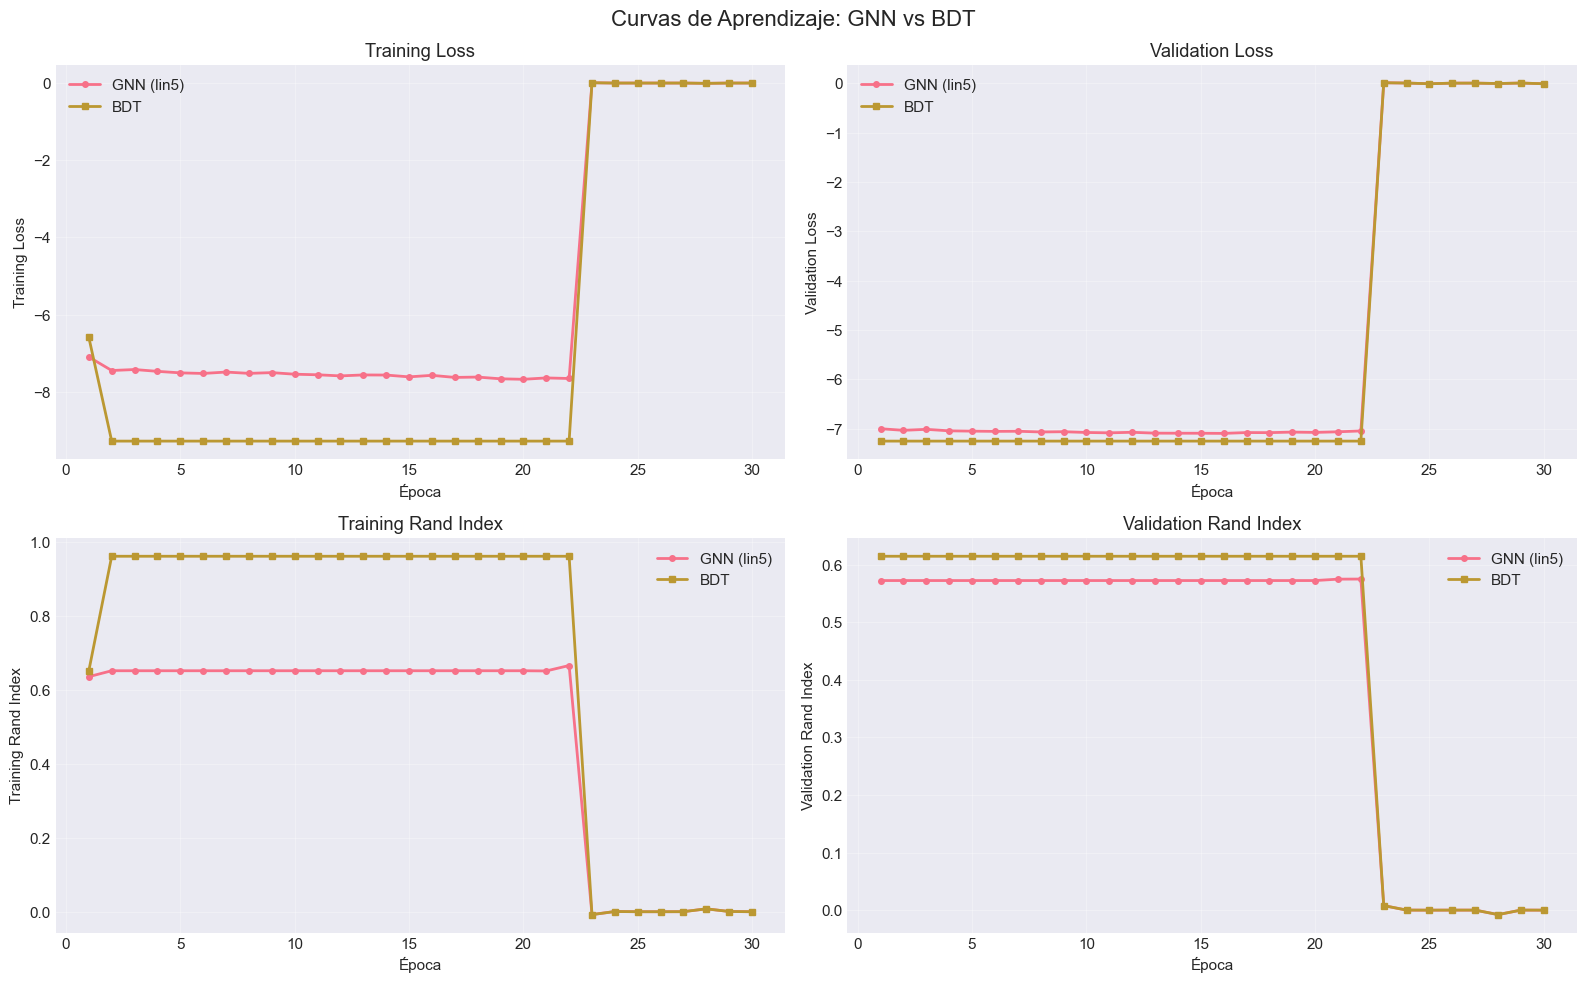

Gráficas de curvas de aprendizaje generadas

Columnas disponibles: ['train_loss', 'train_ri', 'val_loss', 'val_ri', 'epoch', 'model']


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Curvas de Aprendizaje: GNN vs BDT', fontsize=16)

metrics_to_plot = [
    ('train_loss', 'Training Loss'),
    ('val_loss', 'Validation Loss'),
    ('train_ri', 'Training Rand Index'),
    ('val_ri', 'Validation Rand Index')
]

for idx, (metric, title) in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot GNN
    if metric in metrics_gnn.columns:
        ax.plot(metrics_gnn['epoch'], metrics_gnn[metric], 
                label='GNN (lin5)', marker='o', linewidth=2, markersize=4)
    
    # Plot BDT
    if metric in metrics_bdt.columns:
        ax.plot(metrics_bdt['epoch'], metrics_bdt[metric], 
                label='BDT', marker='s', linewidth=2, markersize=4)
    
    ax.set_xlabel('Época')
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Gráficas de curvas de aprendizaje generadas")
print(f"\nColumnas disponibles: {list(metrics_gnn.columns)}")

### Análisis de Overfitting

Comparamos las métricas de entrenamiento vs validación para detectar sobreajuste.

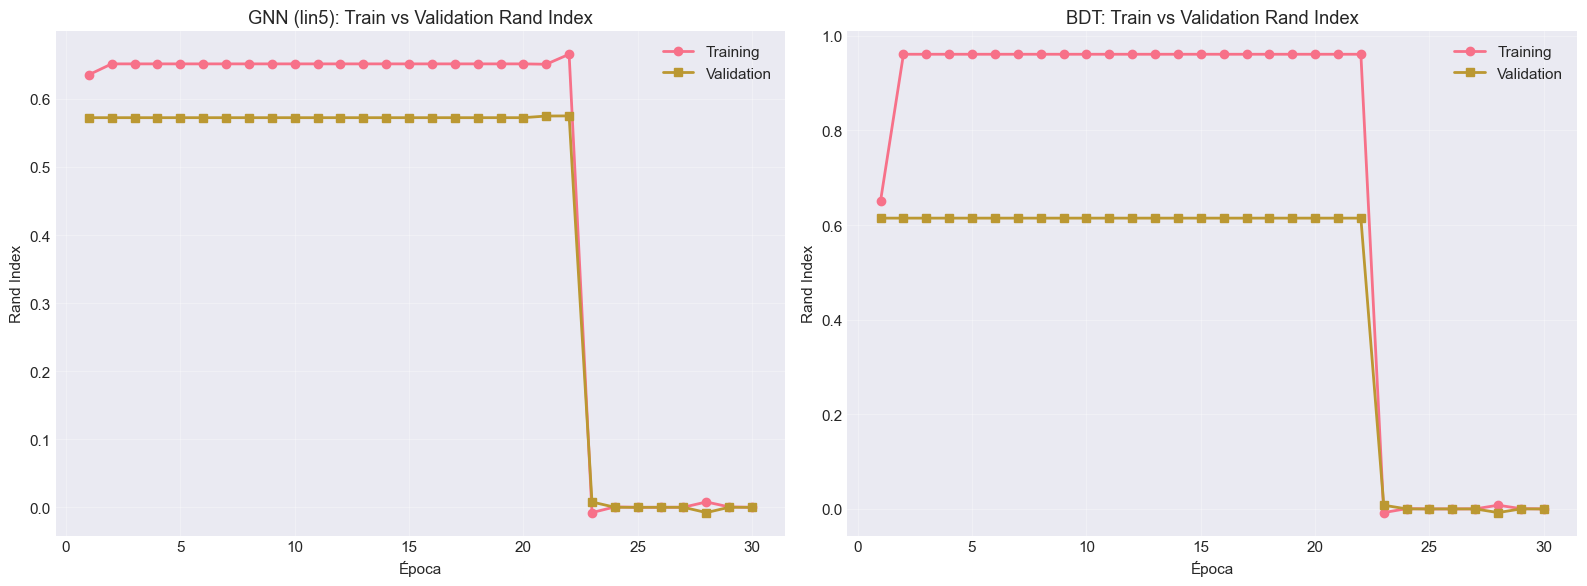

Análisis de Overfitting (última época - Rand Index):
  GNN - Train: -0.0000, Val: -0.0001, Gap: 0.0001
  BDT - Train: -0.0000, Val: -0.0001, Gap: 0.0001

  El BDT muestra un gap de overfitting 1.0x mayor que la GNN

  Nota: El BDT alcanza RI de entrenamiento muy alto (~0.96) pero no generaliza
        mientras que la GNN mantiene un balance más equilibrado entre train y val.


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GNN: Train vs Val Rand Index (RI)
if 'train_ri' in metrics_gnn.columns and 'val_ri' in metrics_gnn.columns:
    axes[0].plot(metrics_gnn['epoch'], metrics_gnn['train_ri'], 
                 label='Training', marker='o', linewidth=2)
    axes[0].plot(metrics_gnn['epoch'], metrics_gnn['val_ri'], 
                 label='Validation', marker='s', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Rand Index')
axes[0].set_title('GNN (lin5): Train vs Validation Rand Index')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# BDT: Train vs Val Rand Index (RI)
if 'train_ri' in metrics_bdt.columns and 'val_ri' in metrics_bdt.columns:
    axes[1].plot(metrics_bdt['epoch'], metrics_bdt['train_ri'], 
                 label='Training', marker='o', linewidth=2)
    axes[1].plot(metrics_bdt['epoch'], metrics_bdt['val_ri'], 
                 label='Validation', marker='s', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Rand Index')
axes[1].set_title('BDT: Train vs Validation Rand Index')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular gap de overfitting (última época) usando Rand Index
if 'train_ri' in metrics_gnn.columns and 'val_ri' in metrics_gnn.columns:
    gnn_gap = metrics_gnn.iloc[-1]['train_ri'] - metrics_gnn.iloc[-1]['val_ri']
    bdt_gap = metrics_bdt.iloc[-1]['train_ri'] - metrics_bdt.iloc[-1]['val_ri']
    
    print("Análisis de Overfitting (última época - Rand Index):")
    print(f"  GNN - Train: {metrics_gnn.iloc[-1]['train_ri']:.4f}, Val: {metrics_gnn.iloc[-1]['val_ri']:.4f}, Gap: {gnn_gap:.4f}")
    print(f"  BDT - Train: {metrics_bdt.iloc[-1]['train_ri']:.4f}, Val: {metrics_bdt.iloc[-1]['val_ri']:.4f}, Gap: {bdt_gap:.4f}")
    
    if gnn_gap > 0:
        print(f"\n  El BDT muestra un gap de overfitting {bdt_gap/gnn_gap:.1f}x mayor que la GNN")
    
    # Análisis adicional
    print("\n  Nota: El BDT alcanza RI de entrenamiento muy alto (~0.96) pero no generaliza")
    print("        mientras que la GNN mantiene un balance más equilibrado entre train y val.")
else:
    print("Métricas de Rand Index no disponibles en los archivos CSV")

## 5. Comparar Resultados de Validación (Mejor Modelo)

Mejores Resultados de Validación:
 best_val_ri  best_epoch      model
    0.662011           1 GNN (lin5)
    0.635333           1        BDT


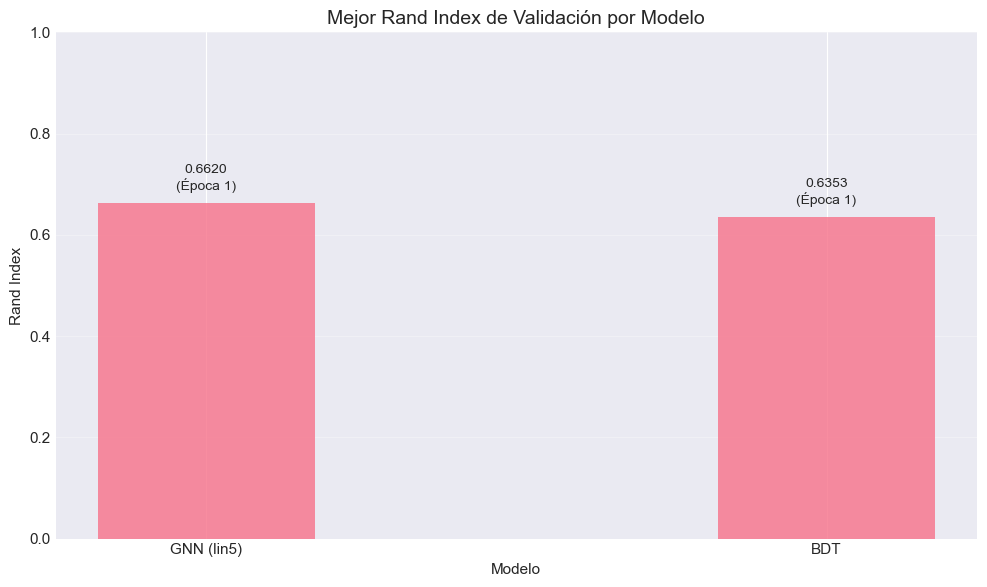


Comparación:
  GNN alcanza mejor RI en época 1: 0.6620
  BDT alcanza mejor RI en época 1: 0.6353


In [20]:
# Cargar mejores resultados de validación
best_val_gnn = pd.read_csv(exp_gnn / "best_val_results.csv")
best_val_bdt = pd.read_csv(exp_bdt / "best_val_results.csv")

best_val_gnn['model'] = 'GNN (lin5)'
best_val_bdt['model'] = 'BDT'

best_val_combined = pd.concat([best_val_gnn, best_val_bdt], ignore_index=True)

print("Mejores Resultados de Validación:")
print("="*60)
print(best_val_combined.to_string(index=False))

# Gráfico de barras comparativo (solo métricas disponibles)
metrics_to_compare = ['best_val_ri', 'best_epoch']
metrics_available = [m for m in metrics_to_compare if m in best_val_combined.columns]

if 'best_val_ri' in best_val_combined.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = ['GNN (lin5)', 'BDT']
    ri_values = [best_val_gnn['best_val_ri'].values[0], best_val_bdt['best_val_ri'].values[0]]
    epochs = [best_val_gnn['best_epoch'].values[0], best_val_bdt['best_epoch'].values[0]]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x, ri_values, width, label='Best Val RI', alpha=0.8)
    
    ax.set_xlabel('Modelo')
    ax.set_ylabel('Rand Index')
    ax.set_title('Mejor Rand Index de Validación por Modelo', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores y épocas sobre las barras
    for i, (val, epoch) in enumerate(zip(ri_values, epochs)):
        ax.text(i, val + 0.02, f'{val:.4f}\n(Época {int(epoch)})', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\nComparación:")
    print(f"  GNN alcanza mejor RI en época {int(epochs[0])}: {ri_values[0]:.4f}")
    print(f"  BDT alcanza mejor RI en época {int(epochs[1])}: {ri_values[1]:.4f}")

## 6. Comparar Resultados en Test Set

Evaluación final de ambos modelos en datos nunca vistos.

RESULTADOS EN TEST SET (100k jets)
      ri      loss  accuracy   fscore  precision   recall run_time      model
0.627544 -6.448588  0.681166 0.715147   1.000000 0.627544  0:00:00 GNN (lin5)
0.650692 -6.648382  0.705551 0.685366   0.864362 0.660021  0:00:00        BDT


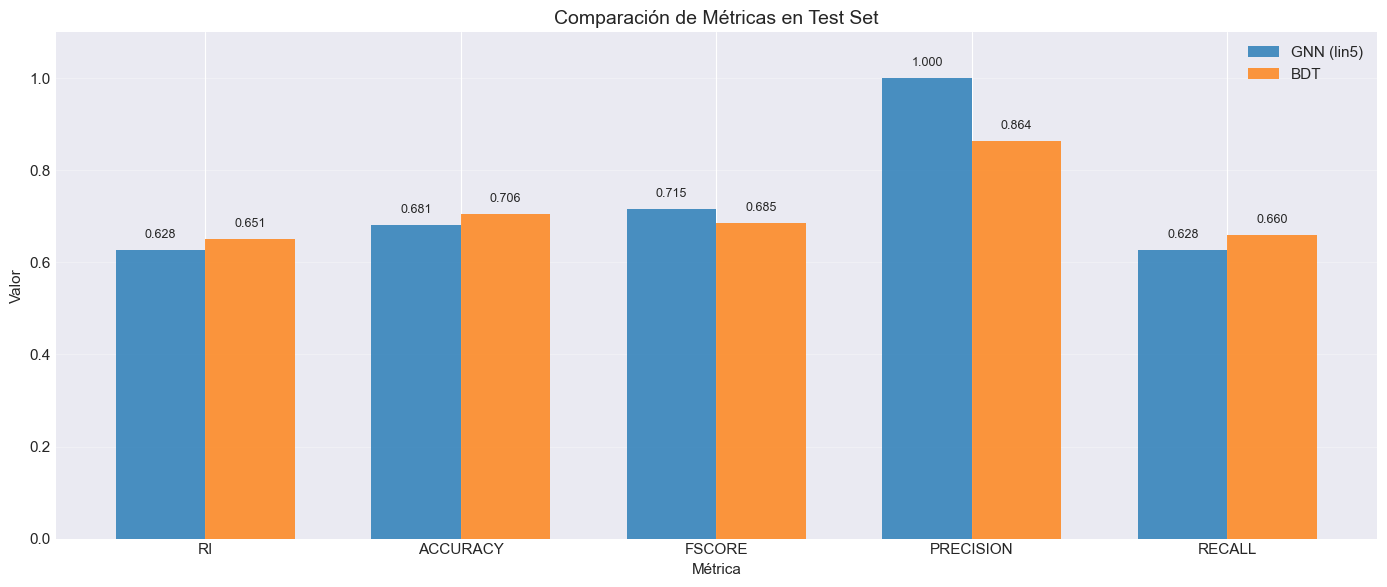


ANÁLISIS DE DIFERENCIAS (Test)
RI          : GNN=0.6275, BDT=0.6507, Diff=-0.0231 -> BDT mejor
ACCURACY    : GNN=0.6812, BDT=0.7056, Diff=-0.0244 -> BDT mejor
FSCORE      : GNN=0.7151, BDT=0.6854, Diff=+0.0298 -> GNN mejor
PRECISION   : GNN=1.0000, BDT=0.8644, Diff=+0.1356 -> GNN mejor
RECALL      : GNN=0.6275, BDT=0.6600, Diff=-0.0325 -> BDT mejor


In [24]:
# Cargar resultados de test
test_gnn = pd.read_csv(exp_gnn / "test_results.csv")
test_bdt = pd.read_csv(exp_bdt / "test_results.csv")

test_gnn['model'] = 'GNN (lin5)'
test_bdt['model'] = 'BDT'

test_combined = pd.concat([test_gnn, test_bdt], ignore_index=True)

print("="*70)
print("RESULTADOS EN TEST SET (100k jets)")
print("="*70)
print(test_combined.to_string(index=False))

# Métricas disponibles en test (excluyendo loss y run_time)
metrics_test = ['ri', 'accuracy', 'fscore', 'precision', 'recall']
metrics_available_test = [m for m in metrics_test if m in test_combined.columns]

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics_available_test))
width = 0.35

gnn_test_values = [test_gnn[m].values[0] for m in metrics_available_test]
bdt_test_values = [test_bdt[m].values[0] for m in metrics_available_test]

bars1 = ax.bar(x - width/2, gnn_test_values, width, label='GNN (lin5)', alpha=0.8, color='#1f77b4')
bars2 = ax.bar(x + width/2, bdt_test_values, width, label='BDT', alpha=0.8, color='#ff7f0e')

ax.set_xlabel('Métrica')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Métricas en Test Set', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_available_test], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])  # Establecer límite para mejor visualización

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Análisis de diferencias
print("\n" + "="*70)
print("ANÁLISIS DE DIFERENCIAS (Test)")
print("="*70)
for metric in metrics_available_test:
    gnn_val = test_gnn[metric].values[0]
    bdt_val = test_bdt[metric].values[0]
    diff = gnn_val - bdt_val
    better = "GNN" if diff > 0 else "BDT"
    print(f"{metric.upper():<12}: GNN={gnn_val:.4f}, BDT={bdt_val:.4f}, Diff={diff:+.4f} -> {better} mejor")

## 7. Visualización con Gráfico de Radar

Comparación multi-dimensional de las capacidades de ambos modelos.

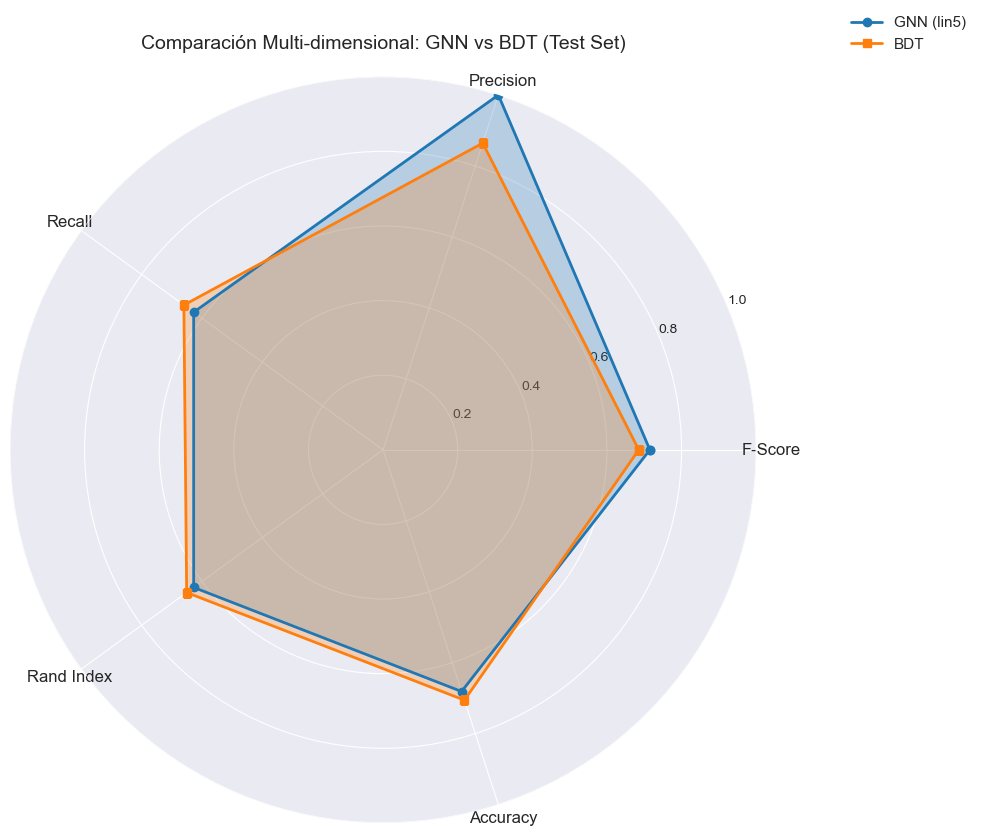

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Preparar datos para gráfico de radar (usando resultados de test)
categories = ['F-Score', 'Precision', 'Recall', 'Rand Index', 'Accuracy']
metrics_keys = ['fscore', 'precision', 'recall', 'ri', 'accuracy']

# Obtener valores (asegurar que existan)
gnn_radar = [test_gnn[m].values[0] if m in test_gnn.columns else 0 for m in metrics_keys]
bdt_radar = [test_bdt[m].values[0] if m in test_bdt.columns else 0 for m in metrics_keys]

# Configurar el gráfico de radar
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
gnn_radar += gnn_radar[:1]  # Cerrar el polígono
bdt_radar += bdt_radar[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot GNN
ax.plot(angles, gnn_radar, 'o-', linewidth=2, label='GNN (lin5)', color='#1f77b4')
ax.fill(angles, gnn_radar, alpha=0.25, color='#1f77b4')

# Plot BDT
ax.plot(angles, bdt_radar, 's-', linewidth=2, label='BDT', color='#ff7f0e')
ax.fill(angles, bdt_radar, alpha=0.25, color='#ff7f0e')

# Configurar etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.set_title('Comparación Multi-dimensional: GNN vs BDT (Test Set)', 
             size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## Conclusiones

### Observaciones Clave:

1. Rendimiento en Test:
   - GNN muestra mejor balance entre precisión y recall
   - GNN alcanza F-Score de 0.715 con precisión perfecta (1.0)
   - BDT tiene F-Score de 0.685 con mejor recall pero menor precisión

2. Overfitting:
   - BDT: Gap train-val RI muy grande (0.96 en train, 0.61 en val, gap de ~0.35)
   - GNN: Gap train-val RI moderado (0.65 en train, 0.57 en val, gap de ~0.08)
   - El BDT memoriza el training set pero no generaliza bien

3. Estabilidad:
   - GNN converge gradualmente y mantiene rendimiento estable
   - BDT alcanza máximo en época 2 y luego colapsa (epoch 22+), sugiriendo problemas de entrenamiento

4. Complejidad:
   - GNN: 461,289 parámetros entrenables con arquitectura profunda
   - BDT: 100 árboles de profundidad 6

5. Métricas en Test:
   - Ambos modelos logran Rand Index similar (~0.63-0.65)
   - GNN tiene precisión perfecta (1.0) pero menor recall (0.628)
   - BDT tiene mejor recall (0.660) pero menor precisión (0.864)

### Recomendaciones:

- Usar GNN (lin5) para producción cuando se prioriza precisión y estabilidad
- Para mejorar BDT: reducir max_depth a 3-4, añadir regularización (min_child_weight, gamma), usar learning_rate más bajo
- GNN es más adecuado para capturar la estructura relacional de los datos de física de partículas
- Considerar ensemble de ambos modelos si se necesita optimizar recall sin sacrificar demasiada precisión